In [1]:
%matplotlib inline
import math 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy import integrate
import csv
import os

## PART 1

In [2]:
xm, ym = np.loadtxt('MainFoil_N=100.txt',dtype=float, delimiter='\t', unpack=True)
xf,yf = np.loadtxt('FlapFoil_N=100.txt',dtype=float, delimiter='\t', unpack=True)

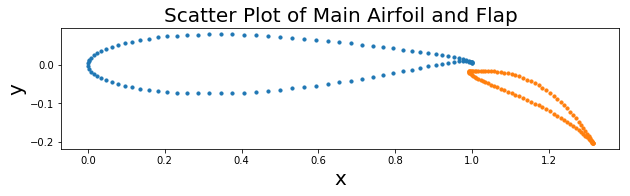

In [3]:
plt.figure(figsize=(10,10))
plt.scatter(xm,ym,s=10)
plt.scatter(xf,yf,s=10)
plt.axis('scaled')
plt.xlabel('x',fontsize=20)
plt.ylabel('y',fontsize=20)
plt.title('Scatter Plot of Main Airfoil and Flap',fontsize=20)


In [4]:
# establish Panel class
class Panel:

    def __init__(self,xa,ya,xb,yb):
        self.xa,self.ya = xa,ya
        self.xb,self.yb = xb,yb
        self.xc, self.yc = (xa + xb)/2, (ya+yb)/2
        self.length = np.sqrt((xb-xa)**2 + (yb-ya)**2)
        
        if xb -xa <= 0.0:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = math.pi + math.acos(-(yb -ya)/self.length)
        
        if self.beta <= math.pi:
            self.loc ='upper'
        else:
            self.loc ='lower'
        self.sigma =0.0
        self.vt =0.0
        self. cp =0.0
        

In [5]:
# create panels given x and y coordinates
def define_panels(x,y):
    
    N = x.size-1
    panels = np.zeros(N,dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i],y[i], x[i+1], y[i+1])
        
    return panels 

In [6]:

panelsm = define_panels(xm,ym)
panelsf =define_panels(xf,yf)


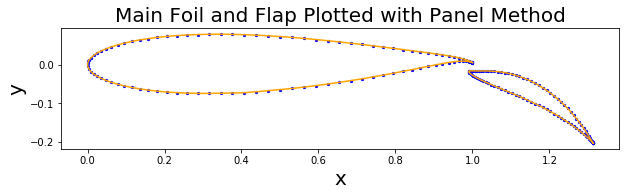

In [7]:
 
plt.figure(figsize=(10,10))
plt.scatter(np.append([p.xa for p in panelsm],panelsm[0].xa),np.append([p.ya for p in panelsm],panelsm[0].ya),s=5,color='blue')
plt.scatter(np.append([p.xa for p in panelsf],panelsf[0].xa),np.append([p.ya for p in panelsf],panelsf[0].ya),s=5,color='blue')
plt.plot(np.append([p.xa for p in panelsm],panelsm[0].xa),np.append([p.ya for p in panelsm],panelsm[0].ya),color='orange')
plt.plot(np.append([p.xa for p in panelsf],panelsf[0].xa),np.append([p.ya for p in panelsf],panelsf[0].ya),color='orange')

plt.axis('scaled')
plt.title('Main Foil and Flap Plotted with Panel Method',fontsize=20)
plt.xlabel('x',fontsize=20)
plt.ylabel('y',fontsize=20)


In [8]:
# define freesstream properties with class
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  
        

In [9]:
# define original u_inf and angle of attack
u_inf = 1.0                            
alpha = 0.0                            
freestream = Freestream(u_inf, alpha) 


In [10]:
# integral function
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + math.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + math.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [11]:
# source portion of A matrix
def source_contribution_normal(panels):
  
    A = np.zeros((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    np.cos(panel_i.beta),
                                                    np.sin(panel_i.beta))
    return A

In [12]:
# vortex portion of A matrix
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.zeros((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     np.sin(panel_i.beta),
                                                     -np.cos(panel_i.beta))
    return A

In [13]:
# concatenate main airfoil and flap panels
panels = np.concatenate((panelsm,panelsf))
A_source = source_contribution_normal(panels)
B_vortex  = vortex_contribution_normal(panels)



In [14]:
# Kutta condition correction
def kutta_condition(A_source, B_vortex,panels):

    N = A_source.shape[0]
    b = np.empty((N,2), dtype=float)
 
    for i, panel in enumerate(panels):
        b[i,0]=np.sum(B_vortex[i,:int(N/2)])
        b[i,1]=np.sum(B_vortex[i,int(N/2):])
    
    return b

In [15]:
# define matrix A for linear equation
def build_singularity_matrix(A_source, B_vortex,panels):
    
    N = A_source.shape[0]
    A = np.zeros((N+2,N+2), dtype=float)
    A2 = np.zeros((N,N+2),dtype=float)
    a = np.zeros((N,2),dtype=float)
    # source contribution matrix
    A[:N, :N] = A_source
    # Kutta condition array
    A[:N, -2] = kutta_condition(A_source, B_vortex,panels)[:,0]
    A[:N, -1] = kutta_condition(A_source, B_vortex,panels)[:,1]
    
    for i, panel in enumerate(panels):
        a[i,0]= -np.sum(A_source[i,:int(N/2)])
        a[i,1]=-np.sum(A_source[i,int(N/2):])
    
    A2[:N,:N]= B_vortex
    A2[:N,-2]= a[:,0]
    A2[:N,-1]=a[:,1]
    
    A3 = np.zeros((2,N+2),dtype=float)
    A3[0,:]=A2[0,:]+A2[int(N/2)-1,:]
    A3[1,:] = A2[int(N/2),:]+A2[-1,:]
    
    A[N:,:]=A3
    
    return A

In [16]:
#  define right-hand-side of linear equation
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    N= panels.shape[0]
    b = np.empty(N+2, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[int(N/2) -1].beta) )
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[int(N/2)].beta) +
                                 np.sin(freestream.alpha - panels[int(N)-1].beta) )
    return b

In [17]:
A = build_singularity_matrix(A_source, B_vortex,panels)
b = build_freestream_rhs(panels, freestream)



In [18]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)


# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]

    
# store circulation density
gamma = strengths[-2:]

gamma

array([ 0.67278868,  0.61832087])

In [19]:
# function for tangential velocity 
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    N =panels.size
    A = np.zeros((N, N + 2), dtype=float)
    a1 = np.zeros((N),dtype=float)
    a2 = np.zeros((N),dtype=float)

    A[:, :N] = B_vortex
    for i, panel in enumerate(panels):
        a1[i] = -np.sum(A_source[i,:int(N/2)])
        a2[i] = -np.sum(A_source[i,int(N/2):])
    A[:,-2]=a1
    A[:,-1]=a2

    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [20]:
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)


In [21]:
# function for pressure coefficients
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

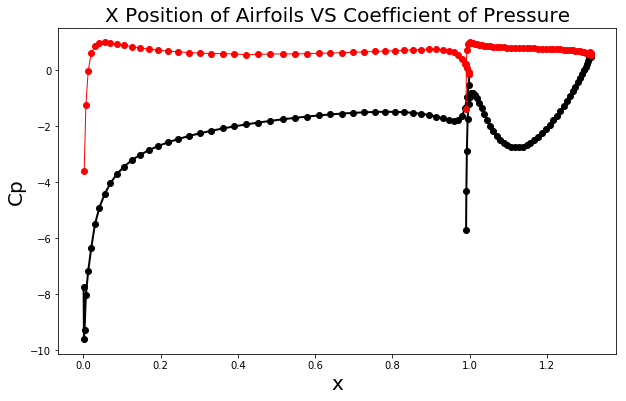

In [22]:
compute_pressure_coefficient(panels, freestream)
plt.figure(figsize=(10, 6))
main = panels[:int(panels.size/2)]
flap = panels[int(panels.size/2):]

plt.plot([panel.xc for panel in  main if panel.loc =='upper'],
            [panel.cp for panel in main if panel.loc =='upper'],
            label='upper surface',
            color='black', linestyle='-', linewidth=2, marker='o', markersize=6)
plt.plot([panel.xc for panel in main if panel.loc =='lower'],
            [panel.cp for panel in main if panel.loc =='lower'],
            label= 'lower surface',
            color='red', linestyle='-', linewidth=1, marker='o', markersize=6)

plt.plot([panel.xc for panel in  flap if panel.loc =='upper'],
            [panel.cp for panel in flap if panel.loc =='upper'],
            label='upper surface',
            color='black', linestyle='-', linewidth=2, marker='o', markersize=6)
plt.plot([panel.xc for panel in flap if panel.loc =='lower'],
            [panel.cp for panel in flap if panel.loc =='lower'],
            label= 'lower surface',
            color='red', linestyle='-', linewidth=1, marker='o', markersize=6)
plt.title('X Position of Airfoils VS Coefficient of Pressure',fontsize=20)
plt.xlabel('x',fontsize=20)
plt.ylabel('Cp',fontsize=20)



In the above graph, the red lines indicate the lower surfaces of the main airfoil and flap, while black depicts the upper surfaces' coefficients of pressure.

Question 1

In [23]:
main[2].cp
# third value of coefficient of pressure on main airfoil

-0.95570117298078072

Question 2

In [24]:
flap[9].cp
# 10th value of coefficient of pressure on flap

-0.27991839836844923

Question 3

In [25]:
lift_100 = 0
drag_100 = 0
for panel in panels:
    lift_100 -= panel.cp*panel.length*np.sin(panel.beta)
    drag_100 += panel.cp*panel.length*np.cos(panel.beta)
print(lift_100,drag_100)
# prints the lift and drag of the 'N=100' airfoil data

3.69771447686 0.0107914032459


In [26]:
#  load airfoil data with 201 values in x and y
xm, ym = np.loadtxt('MainFoil_N=200.txt',dtype=float, delimiter='\t', unpack=True)
xf,yf = np.loadtxt('FlapFoil_N=200.txt',dtype=float, delimiter='\t', unpack=True)


panelsm = define_panels(xm,ym)
panelsf = define_panels(xf,yf)
panels=np.concatenate((panelsm,panelsf))
freestream = Freestream(u_inf=1.0,alpha=0.0)

# create function that calculates lift using panels and freestream data
def lift(panels,freestream):
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
    A = build_singularity_matrix(A_source,B_vortex,panels)
    b = build_freestream_rhs(panels,freestream)
    strengths = np.linalg.solve(A,b)
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
    gamma = strengths[-2:]
    compute_tangential_velocity(panels,freestream,gamma,A_source,B_vortex)
    compute_pressure_coefficient(panels,freestream)
    lift = 0
    drag = 0
    for panel in panels:
        lift -= panel.cp*panel.length*np.sin(panel.beta)
    
    return lift

lift_200 = lift(panels,freestream)
lift_200
# prints value of lift for the 'N=200' airfoil data




3.7184339086781848

In [27]:
lift_act = 3.7386



err = abs(lift_act-lift_100)
err2 = abs(lift_act-lift_200)

print(lift_act)

err_t = abs((err2-err)/err)*100
err_t
# prints theoretical lift and error improvemen between lift_100 and lift_200



3.7386


50.676694894886907

## PART 2

QUESTION 1

In [28]:
# hinge point
x_hinge, y_hinge = 1.03, -0.054

point = np.array([x_hinge,y_hinge])

# define function that changes pitch of the flap
def tail_pitch(point, theta, x, y):
    
    theta_1 = theta/180*np.pi
    x_1, y_1= 0,0
    x_1, y_1 = x-point[0]*np.ones_like(x), y-point[1]*np.ones_like(y)

    x_r = x_1*np.cos(theta_1)+y_1*np.sin(theta_1)+point[0]*np.ones_like(x)
    y_r = x_1*(-1)*np.sin(theta_1)+y_1*np.cos(theta_1)+point[1]*np.ones_like(y)
    
    return x_r, y_r

    
    

    

In [29]:
# load NACA 23012 data
NACA_main =np.loadtxt('NACA23012_MainFoil.txt')
NACA_flap= np.loadtxt('NACA23012_FlapFoil.txt')

xm = NACA_main[:,0]
ym = NACA_main[:,1]

xf = NACA_flap[:,0]
yf =NACA_flap[:,1]


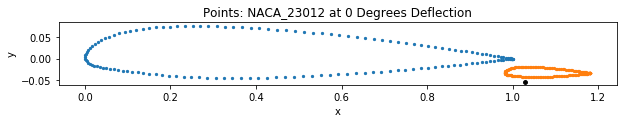

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(xm,ym,s=5)
plt.scatter(xf,yf,s=5)
plt.scatter(x_hinge,y_hinge,s=15,color='black')
plt.axis('scaled')
plt.title('Points: NACA_23012 at 0 Degrees Deflection')
plt.xlabel('x')
plt.ylabel('y')


In [31]:
panelsm = define_panels(xm,ym)
panelsf = define_panels(xf,yf)


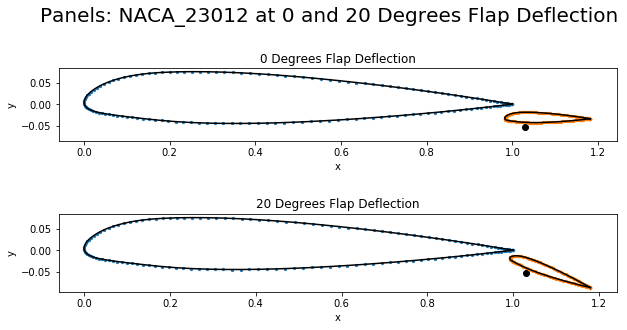

In [32]:
# define panels for a flap deflection of 0 and 20 degrees
xf_new, yf_new = tail_pitch(point,20,xf,yf)


panelsf20 = define_panels(xf_new,yf_new)

plt.figure(figsize=(10,5))
plt.subplot(211)
plt.scatter(x_hinge,y_hinge,color='black')
plt.scatter([panel.xa for panel in panelsm],[panel.ya for panel in panelsm],s=5)
plt.scatter([panel.xa for panel in panelsf],[panel.ya for panel in panelsf],s=5)
plt.plot([panel.xa for panel in panelsm],[panel.ya for panel in panelsm],color='black')
plt.plot([panel.xa for panel in panelsf],[panel.ya for panel in panelsf],color='black')
plt.axis('scaled')
plt.title('0 Degrees Flap Deflection')
plt.xlabel('x')
plt.ylabel('y')


plt.subplot(212)
plt.scatter(x_hinge,y_hinge,color='black')
plt.scatter([panel.xa for panel in panelsm],[panel.ya for panel in panelsm],s=5)
plt.scatter([panel.xa for panel in panelsf20],[panel.ya for panel in panelsf20],s=5)
plt.plot([panel.xa for panel in panelsm],[panel.ya for panel in panelsm],color='black')
plt.plot([panel.xa for panel in panelsf20],[panel.ya for panel in panelsf20],color='black')
plt.axis('scaled')
plt.title('20 Degrees Flap Deflection')
plt.xlabel('x')
plt.ylabel('y')

plt.suptitle('Panels: NACA_23012 at 0 and 20 Degrees Flap Deflection',fontsize=20)

In [33]:
# concatenate main airfoil and 20-degree flap deflection panels
panels = np.concatenate((panelsm,panelsf20))
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [34]:
# use bisection method to find angle of attack where lift = 0
amin = -14
amax = 14
amid = (amin + amax)/2

tolerance = .0001
difference = 1.0

while difference > tolerance:
    freestream = Freestream(u_inf=1.0, alpha=amid)
    lift_tot2 = lift(panels,freestream)
    if lift_tot2 > 0.0: 
        amax = amid
    else:
        amin = amid
    amid = (amin + amax)/2
    difference = abs(amax-amin)
    
    print(lift_tot2)
    
print(amid,lift_tot2)
# prints angle of attack and lift at that angle

1 1.52018626053
2 0.548338462552
3 0.063498906204
4 -0.175476948754
5 -0.0563695467264
6 0.00347652142467
7 -0.0264694255558
8 -0.0115020712276
9 -0.00401416604988
10 -0.000269168393896
11 0.00160359020833
12 0.000667189303793
13 0.000199005050759
14 -3.50830230324e-05
15 8.19606760492e-05
16 2.34387420485e-05
17 -5.82216160585e-06
18 8.80828494274e-06
19 1.49306034873e-06
-10.962894439697266 1.49306034873e-06


QUESTION 2

In [35]:
# redefine freestream with angle of attack of zero
freestream = Freestream(u_inf, 0.0)
defl_min = -20
defl_max = 20
defl_mid = (defl_max+defl_min)/2
tolerance = .01
difference = 1.0
running_total = 0

NACA_flap= np.loadtxt('NACA23012_FlapFoil.txt')
# run bisection method to find tail deflection where lift = 0
xff = NACA_flap[:,0]
yff =NACA_flap[:,1]
while difference > tolerance:
    xf , yf = tail_pitch(point,defl_mid,xff,yff)
    panelsm = define_panels(xm,ym)
    panelsf = define_panels(xf,yf)
    panels = np.concatenate((panelsm, panelsf))
    lift_tot3 = lift(panels,freestream)
    print(defl_mid,lift_tot3)
    if lift_tot3 > 0.0: 
        defl_max = defl_mid
    else:
        defl_min = defl_mid
    defl_mid = (defl_min + defl_max)/2
    difference = abs(defl_max-defl_min)
    running_total =  running_total + 1
# print flap deflection angle and lift at that angle




0.0 0.271910644469
-10.0 -0.325750491927
-5.0 -0.0292849385315
-2.5 0.120733957722
-3.75 0.0455783940187
-4.375 0.00811001236121
-4.6875 -0.0105966660812
-4.53125 -0.00124562455178
-4.453125 0.00343161986053
-4.4921875 0.00109285409613
-4.51171875 -7.64211233554e-05
-4.501953125 0.000508207513314


Question 3

In [36]:
# redefine freestream where angle of attack = 4 degrees
freestream=Freestream(u_inf,4.0)
# define various flap deflection angles
theta_vals=np.array([0,5,10,15])

xfs = np.zeros([xm.shape[0],4])
yfs = np.zeros([xm.shape[0],4])
for i in range(theta_vals.shape[0]):
    xfs[:,i],yfs[:,i] = tail_pitch(point,theta_vals[i],xff,yff)

# find flap panels depending on deflection angle
panelsf0 = define_panels(xfs[:,0],yfs[:,0])
panelsf1 = define_panels(xfs[:,1],yfs[:,1])
panelsf2 = define_panels(xfs[:,2],yfs[:,2])
panelsf3 = define_panels(xfs[:,3],yfs[:,3])

panels0 = np.concatenate((panelsm,panelsf0))
panels1 = np.concatenate((panelsm,panelsf1))
panels2 = np.concatenate((panelsm,panelsf2))
panels3 = np.concatenate((panelsm,panelsf3))

# solve for lift of main airfoil and deflected flaps
lift0 = lift(panels0,freestream)
lift5 = lift(panels1,freestream)
lift10 = lift(panels2,freestream)
lift15 = lift(panels3,freestream)

print(lift0, lift5,lift10,lift15)
# prints lift at each angle of deflection for airfoil systems

0.824359758886 1.12804894952 1.43522694191 1.74566935538


In [41]:
vdiff0 = (1- (np.sqrt([(lift0)])/np.sqrt([lift0])))
vdiff5 = (1- (np.sqrt([(lift0)])/np.sqrt([lift5])))
vdiff10 = (1- (np.sqrt([(lift0)])/np.sqrt([lift10])))
vdiff15 = (1- (np.sqrt([(lift0)])/np.sqrt([lift15])))

print(vdiff5, vdiff10, vdiff15)
# prints percentage of velocity decrease from 0-degree baseline before lift is no longer achieved

[ 0.14514114] [ 0.24212409] [ 0.3128091]


THINK1: A large source of difference between the theoretical and the Python-calculated data is the resolution of the given airfoils. The greater the number of points, the higher the resoultion and accuracy will be for the calculated results.

THINK2: Deflecting flaps allows the same amount of lift to be achieved at lower speeds. This means that an aircraft can take off over a shorter distance of runway. It also means that an aircraft can land more smoothly at lower speeds.